# Method to analyze whether SNV in ETS

In [1]:
tfbsType='ETS'
tfName='ETS'

expname='GEUV'

In [2]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import helper_functions as hf
import sigfig as sf

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import os

In [3]:
def getAll8mers(seq,p,ref,alt):
    
    altLenAdj=len(ref)-len(alt)
        
    if altLenAdj==0:
        seq=seq[p-7:p+8]    
        seqRef=seq[:7]+ref+seq[7+1:]
        seqAlt=seq[:7]+alt+seq[7+1:]
        
    elif altLenAdj>0:
        seq=seq[p-7:p+8+altLenAdj]    
        seqRef=seq[:7]+ref+seq[7+1:-altLenAdj]
        seqAlt=seq[:7]+alt+seq[7+1:]
    else:
        raise ValueError('ref/alt not allowed yet')
    
    # if len(seqRef)!=len(seqAlt):
        # raise ValueError('ref/alt seqs not dovetailed')
        
    for i,end in enumerate(range(7,len(seq)-altLenAdj)):
        start=end-7
        last=end+1
        kmer8Ref=seqRef[start:last]
        kmer8Alt=seqAlt[start:last]
            
        yield kmer8Ref,kmer8Alt
                    #.  012345678901234567890
            
# for i in getAll8mers(chr2seq['chr7'], 156791183, 'T', ''):
    # print(i)
            

In [4]:
def ets(kmer4):
    if kmer4 in ['GGAA','GGAT','TTCC','ATCC']: return True
    else:                                      return False

# Set up logic for creating/deleting ets sites
BeforeAfter2EtsLogic={
    (0,0):'Ets Never',
    (1,1):'Ets Always',
    (0,1):'Ets Created',
    (1,0):'Ets Deleted'
}

In [5]:

def snv_ets_analysis(chrom,idx1,ref,alt,chr2seq,tf2aff):
    
    # Ensure data is snp, no indels
    prohibitedPolyTypes=['Other']
    if len(ref)==1 and len(alt)==1: 
        polymorphismType='SNV'
        
    elif len(ref)==1 and len(alt)==0:
        polymorphismType='SND'
        
    else:
        polymorphismType='Other'
        
    if polymorphismType in prohibitedPolyTypes:
        return 'Variant Type Not Allowed Yet'
        
    ######################################
    # Verify ref/alt matches genomic bp
    ######################################
    
    if 'chr' not in chrom: chrom=f'chr{chrom}'
    
    # Check if pos in genome is same as declared REF
    idx0=int(idx1)-1
    snvNtInGenome=chr2seq[chrom][idx0]
    if ref==snvNtInGenome:    
        checkSnv='REF'
    elif alt==snvNtInGenome:  
        checkSnv='ALT'
    else:                     
        return f'Genomic bp does not match expectation: \n  expected ref/alt = ({ref}/{alt})\n  observed = {snvNtInGenome}'
    
    
    ######################################
    # Assess if SNV is in ETS
    ######################################
    
    etsChanged=False
    for kmer8,kmer8mut in getAll8mers(chr2seq[chrom],idx0,ref,alt):
        core   =kmer8[2:6]
        coremut=kmer8mut[2:6]

        ba=(ets(core),ets(coremut)) # before after logic
        etsLogic=BeforeAfter2EtsLogic[ba]

        # If ets-changing snp found, write it out
        if etsLogic=='Ets Always': 
            etsChanged=True
            refaff=tf2aff[kmer8]
            altaff=tf2aff[kmer8mut]
            
            return etsLogic,refaff,altaff,altaff/refaff,kmer8,kmer8mut
        
        elif etsLogic=='Ets Created':
            return etsLogic,kmer8,kmer8mut
            
        elif etsLogic=='Ets Deleted':
            return etsLogic,kmer8,kmer8mut

    if etsChanged==False:
        return 'Variant not in ETS',kmer8,kmer8mut


# Load ref data

In [6]:
# Ets1
ref  =f'preprocessed-data//parsed_Ets1_8mers.txt'              
Seq2EtsAff  = hf.loadAff(ref)
hf.dprint(Seq2EtsAff)


# hg38
ref='/Users/joe/code/ref/genomes/human/hg38/fasta/hg38.fa'
chr2seq=hf.faLoadGenome(ref)

AAAAAAAA 0.14700431859740803


# Analysis options

In [7]:
fcOptCutoff=1.59
# fcOptCutoff=3.46


# Load MPRA data

In [8]:

fn=f'preprocessed-data/QTD000110__readyForInput__matteoCorrMethod_keepOnlyTewheyMPRAVariants=False_removeMixedGofLofVariants=False_genomeWideSigAdj=True.tsv'

df=pd.read_csv(fn,sep='\t')
df.head(2)

/var/folders/r8/cnsr_ylj6qd449cvnpt46c6w0000gn/T/ipykernel_4412/416347832.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(fn,sep='\t')


,chrom,pos,rsid,ref,alt,beta,pvalue-bonf,gene-id
0,1,624836,rs1220600689,G,A,0.940218,2.706912e-02,ENSG00000237491
1,1,656599,rs1265125318,C,T,1.175120,9.004911e-11,ENSG00000237491


In [9]:
# only snvs
df=df.loc[(df.ref.str.len()==1) & (df.alt.str.len()==1),:]

In [10]:
len(df)

369912

In [11]:
## New one which grabs 8mer ref and  8mer alt  regardlesso f snv  type

variantTypeList=[]
refAffList=[]
altAffList=[]
fcList=[]
ref8merlist=[]
alt8merlist=[]

for idx in df.index:
    
    chrom,pos,ref,alt=[df.at[idx,ci] for ci in ['chrom','pos','ref','alt']]

    if alt=='-': alt=''
    resultList=snv_ets_analysis(str(chrom),pos,ref,alt,chr2seq,Seq2EtsAff)
    result=resultList[0]
    
    if result=='Variant not in ETS':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Not In Ets')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)


    elif result=='Ets Created':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Ets Created')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)


    elif result=='Ets Deleted':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Ets Deleted')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)

        
    else:
        variantType,refAff,altAff,fc,kmer8ref,kmer8alt=resultList
        variantTypeList.append(variantType)
        refAffList.append(refAff)
        altAffList.append(altAff)
        fcList.append(fc)
        ref8merlist.append(kmer8ref)
        alt8merlist.append(kmer8alt)


In [12]:
df['variant-type']=variantTypeList
df['aff-ref']=refAffList
df['aff-alt']=altAffList
df['aff-fc']=fcList
df['kmer-ref']=ref8merlist
df['kmer-alt']=alt8merlist

df['aff-delta']=df.apply(lambda row: row['aff-alt']-row['aff-ref'],axis=1)

In [13]:
df['variant-type'].value_counts()

Not In Ets     310189
Ets Always      23236
Ets Deleted     18293
Ets Created     18194
Name: variant-type, dtype: int64

In [14]:
df=df.loc[df['pvalue-bonf']<.01,:]
df['-log(p)']=df['pvalue-bonf'].apply(lambda p: -np.log10(p))
df['-log(p)*direction']=df.apply(lambda r: r['-log(p)'] if r['beta']>=0 else -r['-log(p)'],axis=1)

In [15]:
df['pvalue-bonf'].max()

0.0099996102304098

In [16]:
df['pvalue-bonf'].min()

4.488672107634e-167

In [17]:
df.loc[df['variant-type']!=False,:].head(5)

,chrom,pos,rsid,ref,alt,beta,pvalue-bonf,gene-id,variant-type,aff-ref,aff-alt,aff-fc,kmer-ref,kmer-alt,aff-delta,-log(p),-log(p)*direction
1,1,656599,rs1265125318,C,T,1.17512,9.004911e-11,ENSG00000237491,Not In Ets,NaN,NaN,NaN,CAATCTTA,TAATCTTA,NaN,10.045521,10.045521
2,1,683066,rs562831530,G,A,1.26204,2.873912e-30,ENSG00000237491,Ets Always,0.10717,0.099166,0.925315,CGATCCCC,CAATCCCC,-0.008004,29.541526,29.541526
3,1,720695,rs71224409,G,C,1.40110,8.231815e-30,ENSG00000237491,Not In Ets,NaN,NaN,NaN,GTTGCCCA,CTTGCCCA,NaN,29.084504,29.084504
4,1,761341,rs879871932,G,A,1.37963,6.958911e-30,ENSG00000237491,Not In Ets,NaN,NaN,NaN,GGGAGAGT,AGGAGAGT,NaN,29.157459,29.157459
6,1,762507,rs867870715,G,C,1.38016,1.021355e-31,ENSG00000237491,Not In Ets,NaN,NaN,NaN,GGCTACCT,CGCTACCT,NaN,30.990823,30.990823


In [18]:
df['variant-type'].value_counts()

Not In Ets     280727
Ets Always      21081
Ets Deleted     16568
Ets Created     16512
Name: variant-type, dtype: int64

In [19]:
df['chrompos']=df['chrom'].apply(lambda c: 'chr'+str(c))+df['pos'].apply(str)
print(len(df['chrompos']))
print(len(df['chrompos'].unique()))

334888
246431


In [20]:
print(len(df))
df=df.drop_duplicates()
print(len(df))

334888
334888


# Prediction accuracy vs random (for nature)

In [21]:

fcOptCutoff=1.59
fcOptCutoff=3.46
# fcOptCutoff=5

fcDecCutoff=1/fcOptCutoff

pvalCutoff=.05
logSigCutoff=abs(np.log10(pvalCutoff))

fcNoChangeCutoff_Inc=1.25
fcNoChangeCutoff_Dec=sf.round(1/fcNoChangeCutoff_Inc,3)

deNovoThresh=.15

# get variants to predict on
predDF=df.loc[:,:]

# assign prediction labels
bins=[-np.inf,-logSigCutoff-1e-100,logSigCutoff,np.inf]
predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])

# assign predictions
etsLabels=[]

for fc,classification,kmer,kmerMut in hf.zipdf(predDF,['aff-fc','variant-type','kmer-ref','kmer-alt']):

    # not in tf
    if classification=='Not In Ets':
        anno='not-in-tf'

    # delet tf
    elif classification=='Ets Deleted':
        anno='del-tf'

    elif classification=='Ets Created':

        denovoaff=Seq2EtsAff[kmerMut]

        if denovoaff<deNovoThresh:
            anno=f'de-novo-tf-low-aff\n<{deNovoThresh}'            

        elif denovoaff>=deNovoThresh:
            anno=f'de-novo-tf-high-aff\n>={deNovoThresh}'

    #  dramatic iincrase
    elif fc>=fcOptCutoff:
        anno=f'dramatic-increase\n>={fcOptCutoff}'

    #  dramatic incrase
    elif fc<=fcDecCutoff:
        # print(fc,classification)
        anno=f'dramatic-decrease\n<={fcDecCutoff}'

    # no increase
    elif fc<=fcNoChangeCutoff_Inc and fc>=fcNoChangeCutoff_Dec:
        anno=f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'
        # print(anno.replace('\n',' '),fc,classification,kmer,kmerMut)


    else:
        anno='subtle-change'
        # print(anno.replace('\n',' '),fc,classification,kmer,kmerMut)


    etsLabels.append(anno)

predDF['ets-class']=etsLabels

line_out=hf.write_row(['snv-group','total','effect-ns','effect-gof','effect-lof'])

for classi in predDF['ets-class'].unique():
    nClassi=predDF['ets-class'].value_counts()[classi]

    ns,gof,lof=[predDF.loc[predDF['ets-class']==classi,'classification'].value_counts()[ci] for ci in ['N.S.','Sig Increase','Sig Decrease']]

    line_out+=hf.write_row([classi.replace('\n',' '),nClassi,ns,gof,lof])

print(line_out)
with open(f'FOR-NATURE-STATS-PREDICTIONS-{expname}-{tfName}__fdr.tsv','w') as f: f.write(line_out)

/Users/joe/miniconda3/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


snv-group	total	effect-ns	effect-gof	effect-lof
not-in-tf	280727	0	136709	144018
no-change-aff <=1.25 >=0.8	14338	0	6996	7342
del-tf	16568	0	8012	8556
de-novo-tf-low-aff <0.15	12933	0	6270	6663
subtle-change	6052	0	2939	3113
dramatic-decrease <=0.28901734104046245	383	0	163	220
de-novo-tf-high-aff >=0.15	3579	0	1756	1823
dramatic-increase >=3.46	308	0	183	125



In [22]:
altHypothesis='less'


datalabels_subset_v2=[
[f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'],
[f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'],
[f'dramatic-increase\n>={fcOptCutoff}'],
]

data2color={
(f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}',):'lightgrey',
(f'dramatic-increase\n>={fcOptCutoff}',):'forestgreen',
(f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'):'dimgrey'}

plotDF=predDF.loc[:,:].reset_index().copy(deep=True)


In [23]:
rsid2mostsigrow={}

for i,(rsid,pvalue) in enumerate(hf.zipdf(plotDF,['rsid','pvalue-bonf'])):
    
    if rsid not in rsid2mostsigrow:
        rsid2mostsigrow[rsid]=i
        
    else:
        #update if this is more sig
        if pvalue<rsid2mostsigrow[rsid]:
            rsid2mostsigrow[rsid]=i

idxToKeep=rsid2mostsigrow.values()
plotDF=plotDF.loc[idxToKeep,:]

In [24]:
lo=hf.getLiftoverObject('hg38','hg19')
plotDF['pos19']=plotDF.apply(lambda row: hf.liftover_pos(lo,'chr'+str(row['chrom']),row['pos'])[1],axis=1)

group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.28901734104046245+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	no-change-aff <=1.25 >=0.8	0.2746
not-in-tf+del-tf+dramatic-decrease <=0.28901734104046245+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	dramatic-increase >=3.46	0.01148



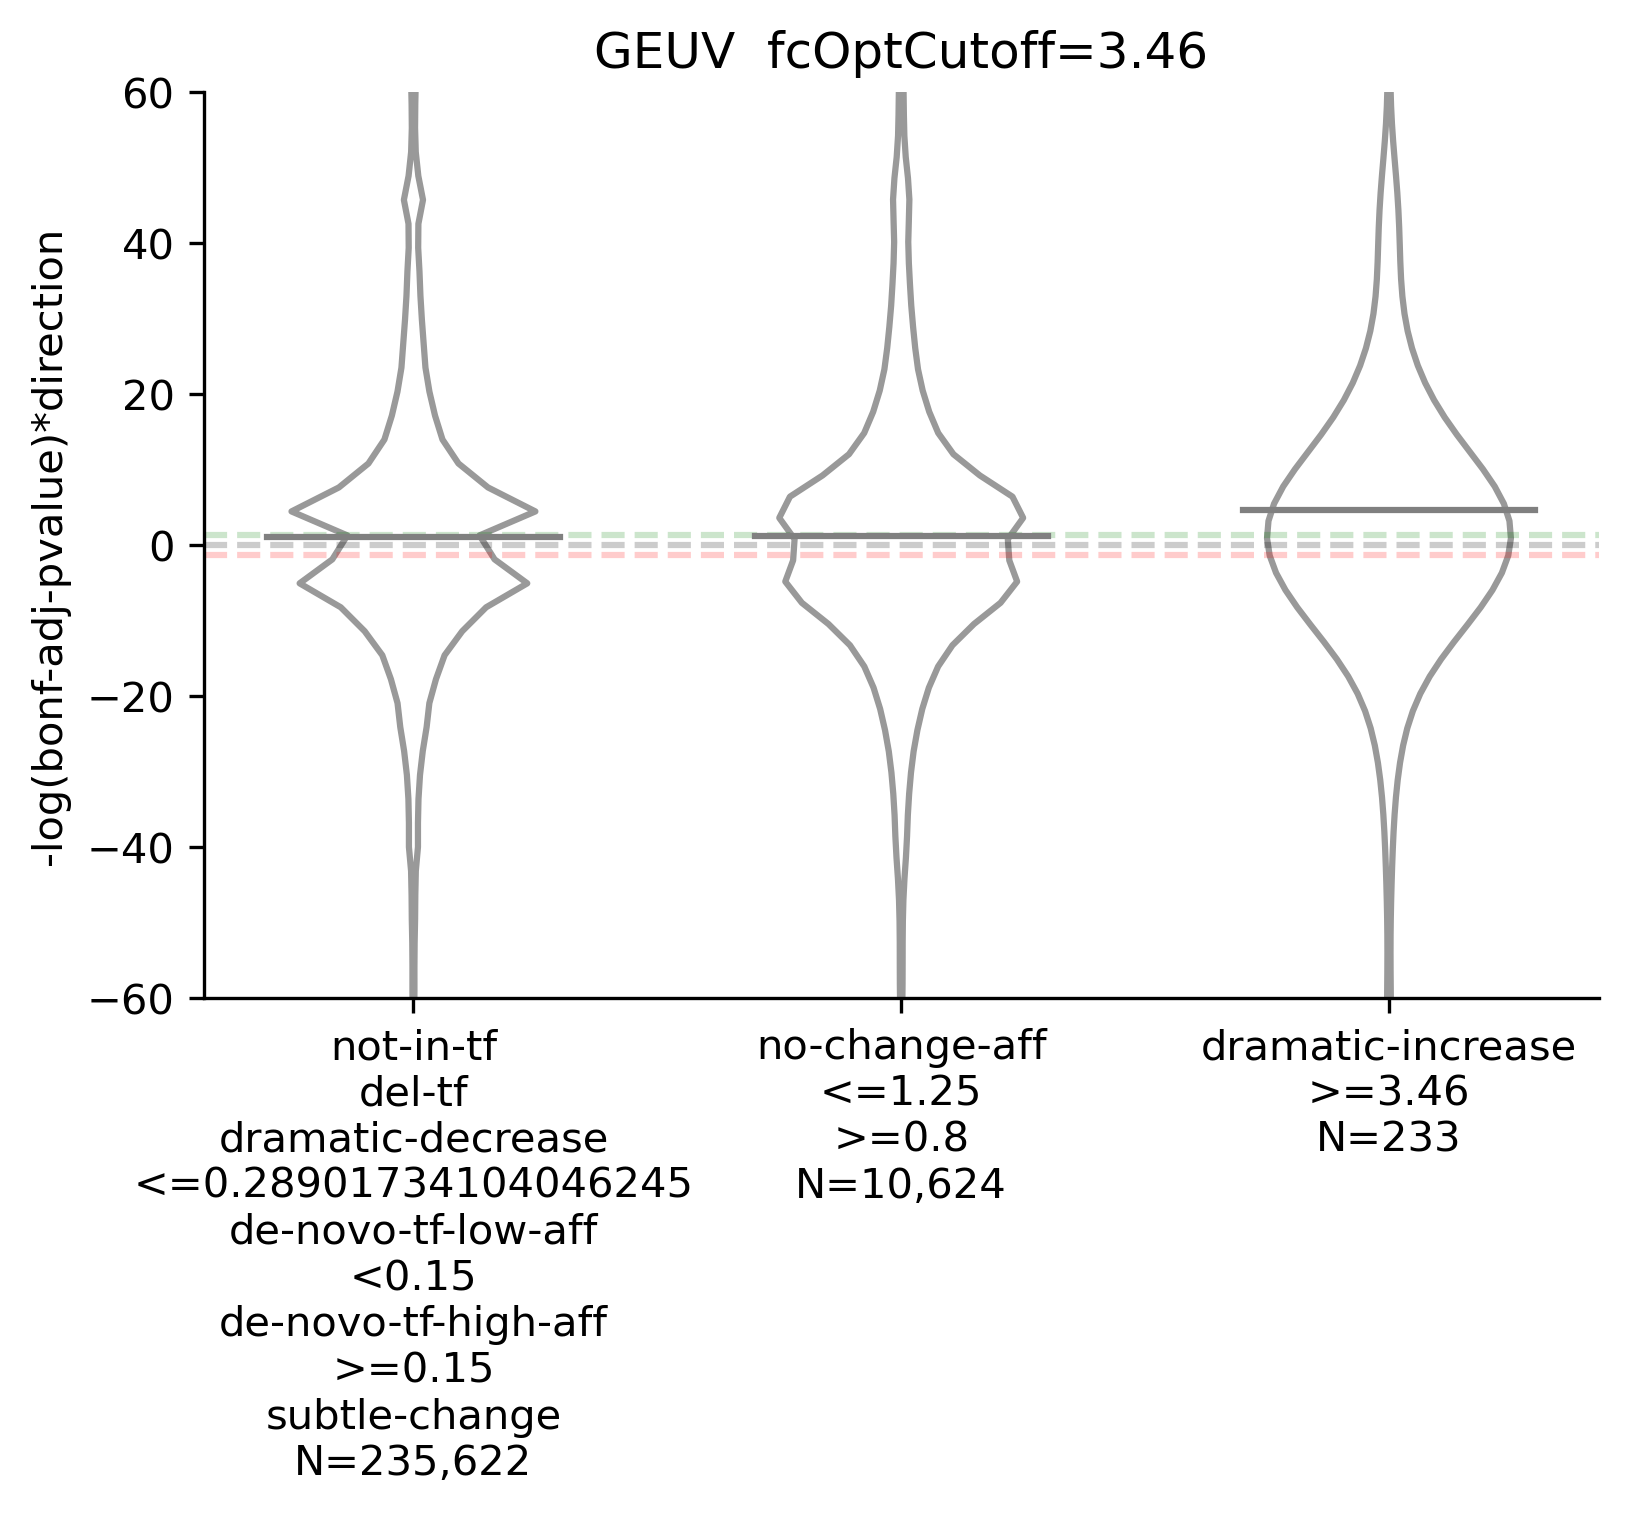

In [25]:
violin=True
boxplot=False




data=[]
for di in datalabels_subset_v2:
    datai=[]
    for dj in di:
        datai+=plotDF.loc[(plotDF['ets-class']==dj),'-log(p)*direction'].tolist()
    data.append(datai)

line_out=hf.write_row(['group1','group2','p'])

############################################################################
# Stats
############################################################################

dCtrlNameList=datalabels_subset_v2[0]
dCtrl=plotDF.loc[(plotDF['ets-class'].isin(dCtrlNameList)),'-log(p)*direction']

for diNameList in datalabels_subset_v2[1:]:

    di=plotDF.loc[(plotDF['ets-class'].isin(diNameList)),'-log(p)*direction']

    try:
        _ , p =stats.mannwhitneyu(dCtrl,di,alternative=altHypothesis)
    except ValueError:
        pass


    line_out+=hf.write_row(['+'.join(dCtrlNameList).replace('\n',' '),'+'.join(diNameList).replace('\n',' '),sf.round(p,4)])

print(line_out)
with open(f'FOR-NATURE__violin-stats__{tfName}__{expname}.tsv','w') as f: f.write(line_out)

############################################################################
# Stats
############################################################################

fig,ax=plt.subplots(1,1,figsize=(2*len(datalabels_subset_v2),4),dpi=300,facecolor='white')

palette=[data2color[tuple(di)] for di in datalabels_subset_v2]

ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axhline(np.log10(.05),ls='--',color='red',alpha=.2)
ax.axhline(np.log10(1),ls='--',color='black',alpha=.2)

if violin:
    sns.violinplot(data=data,color='white',inner=None,cut=0,ax=ax,width=.5,scale='width')

    meanlinewidth=.3
    for xi,di in enumerate(data):
        val=np.mean(di)
        ax.plot([xi-meanlinewidth,xi+meanlinewidth],[val,val],color='grey')

if boxplot:
    sns.boxplot(data=data,color='white',ax=ax,fliersize=0)#,palette=palette)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axticklabels=['\n'.join(label) for label in datalabels_subset_v2]
ax.set_xticklabels([f'{label}\nN={len(points):,}' for label,points in zip(axticklabels,data)])
ax.set_ylabel('-log(bonf-adj-pvalue)*direction')

ax.set_title(f'{expname}  fcOptCutoff={fcOptCutoff}')
ax.set_ylim(-60,60)

plt.show()


